In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit # Numerically stable sigmoid function
from scipy.optimize import curve_fit
import statsmodels.api as sm

simulations = 1

# Import Data
# Set print options to suppress scientific notation
np.set_printoptions(suppress=True)

df_profit_list_all = []

for year in [2014]:
    
    
    period = ['may-jun', 'jun-jul']

    # Import data
    if year == 2014:
        X = np.load('../data/processed/data_2014.npz')

    elif year == 2015:
        X = np.load('../data/processed/data_2015.npz')

    elif year == 2016:
        X = np.load('../data/processed/data_2016.npz')
        
    elif year == 2017:
        X = np.load('../data/processed/data_2017.npz')

    N = X['N']

    distance = X['distance']
    dist = X['distance']
    #tI1 = X['tI1'].reshape(N,1)
    #tI2 = X['tI2'].reshape(N,1)
    sI2 = X['sI2'].reshape(N,1)

    y_apr = X['y_apr'].reshape(N,1)
    y_may = X['y_may'].reshape(N,1)
    y_jun = X['y_jun'].reshape(N,1)
    y_jul = X['y_jul'].reshape(N,1)

    n_apr = X['n_apr'].reshape(N,1)
    n_may = X['n_may'].reshape(N,1)
    n_jun = X['n_jun'].reshape(N,1)
    n_jul = X['n_jul'].reshape(N,1)

    area_apr = X['a_apr'].reshape(N,1)
    a_apr = X['a_apr'].reshape(N,1)
    a_may = X['a_may'].reshape(N,1)
    a_jun = X['a_jun'].reshape(N,1)
    a_jul = X['a_jul'].reshape(N,1)

    w_apr = X['wind_apr']
    w_may = X['wind_may']
    w_jun = X['wind_jun']
    w_jul = X['wind_jul']

    sI1_apr = X['sI1_apr'].reshape(N,1)
    sI1_may = X['sI1_may'].reshape(N,1)
    sI1_jun = X['sI1_jun'].reshape(N,1)
    sI1_jul = X['sI1_jul'].reshape(N,1)

    s_apr = X['s_apr'].reshape(N,1)
    s_may = X['s_may'].reshape(N,1)
    s_jun = X['s_jun'].reshape(N,1)
    s_jul = X['s_jul'].reshape(N,1)

    # Convert to float64
    dist = dist.astype(np.float64)
    #tI1 = tI1.astype(np.float64)
    #tI2 = tI2.astype(np.float64)
    sI2 = sI2.astype(np.float64)

    y_apr = y_apr.astype(np.float64)
    y_may = y_may.astype(np.float64)
    y_jun = y_jun.astype(np.float64)
    y_jul = y_jul.astype(np.float64)

    n_apr = n_apr.astype(np.float64)
    n_may = n_may.astype(np.float64)
    n_jun = n_jun.astype(np.float64)
    n_jul = n_jul.astype(np.float64)

    a_apr = a_apr.astype(np.float64)
    a_may = a_may.astype(np.float64)
    a_jun = a_jun.astype(np.float64)
    a_jul = a_jul.astype(np.float64)

    w_apr = w_apr.astype(np.float64)
    w_may = w_may.astype(np.float64)
    w_jun = w_jun.astype(np.float64)
    w_jul = w_jul.astype(np.float64)

    sI1_apr = sI1_apr.astype(np.float64)
    sI1_may = sI1_may.astype(np.float64)
    sI1_jun = sI1_jun.astype(np.float64)
    sI1_jul = sI1_jul.astype(np.float64)

    s_apr = s_apr.astype(np.float64)
    s_may = s_may.astype(np.float64)
    s_jun = s_jun.astype(np.float64)
    s_jul = s_jul.astype(np.float64)

    area_hectares = a_apr

    # Function to normalize the data
    def norm(x):
        
        return (x - np.min(x)) / (np.max(x) - np.min(x))

    # Normalize the data
    # dist = norm(dist)

    # a_apr = norm(a_apr)
    # a_may = norm(a_may)
    # a_jun = norm(a_jun)
    # a_jul = norm(a_jul)
    
        # Function to normalize the data
    def norm(x):
        
        return (x - np.min(x)) / (np.max(x) - np.min(x))

    # # Normalize the data
    # dist = norm(dist)

    # a_apr = norm(a_apr)
    # a_may = norm(a_may)
    # a_jun = norm(a_jun)
    # a_jul = norm(a_jul)

    # w_apr = norm(w_apr)
    # w_may = norm(w_may)
    # w_jun = norm(w_jun)
    # w_jul = norm(w_jul)


    # Import Paramaters
        
    #theta_may_jun = np.load('../reports/parameters/theta_may-jun_power.npy', allow_pickle=True)
    # theta_may_jun = np.array([-2.06487009,
    #                    -4.15663255,
    #                    2169.18203419,
    #                    120.90338129,
    #                    36530.91421416,
    #                    18164.75229185,
    #                    0.71057956,
    #                    2.67634927,
    #                    3.55546038,
    #                    1.61401027,
    #                    3.00066525,
    #                    0.47313149]).reshape(12,1)
    # theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_power.npy', allow_pickle=True)
    theta_may_jun = np.load('../reports/parameters/theta_may-jun_power_oct25.npy', allow_pickle=True)
    theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_power_oct25.npy', allow_pickle=True)

    # Safe exponential function
    def safe_exp(x):
        """Prevent overflow of exponential function."""
        # np.finfo('d').max is the maximum representable positive number
        # np.log(np.finfo('d').max) is the maximum number that can be exponentiated without overflow
        # We clamp x to this range before taking the exponent
        x = np.clip(x, None, np.log(np.finfo('d').max))
        return np.exp(x)

    # Define the function eta() which takes input parameters theta and returns the log-odds of disease for each yard i in current time period

    def eta(period, y_lag, sprays):
        
        y_lag = y_lag
        n_lag = n
        
        if period == 'may-jun':
            theta = theta_may_jun
            #y_lag = y_may
            #n_lag = n_may
            a_lag = a_may
            w_lag = w_may
            #sI1_lag = sI1_may
            s_lag = sprays # need to fix this to be a conditional function

        elif period == 'jun-jul':
            theta = theta_jun_jul
            #y_lag = y_jun
            #n_lag = n_jun
            a_lag = a_jun
            w_lag = w_jun
            #sI1_lag = sI1_jun
            s_lag = predict_sprays(period, sprays)
            
        beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
        
        beta1_array = np.full((N,1), beta1)
        beta2_array = np.full((N,1), beta2)
        
        auto_infection1 = delta1 * (y_lag / n_lag) * np.exp(-eta11 * s_lag)
        auto_infection2 = delta2 * (y_lag / n_lag) * np.exp(-eta12 * s_lag)
        
        dispersal1 = []
        dispersal2 = []
        
        eta_1 = [] 
        
        for i in range(0, N):
            
            dispersal_array = ((a_lag * (y_lag / n_lag)) * (w_lag[:, i].reshape(N,1)))
            dispersal_array1 = dispersal_array * np.exp(-eta21 * s_lag) * np.power(1 + dist[:, i].reshape(N,1), -alpha1) * sI1_lag
            dispersal_array2 = dispersal_array * np.exp(-eta22 * s_lag) * np.power(1 + dist[:, i].reshape(N,1), -alpha2) * sI2
            dispersal_component1_i = gamma1 * (np.sum(dispersal_array1) - dispersal_array1[i][0])
            dispersal_component2_i = gamma2 * (np.sum(dispersal_array2) - dispersal_array2[i][0])
            
            dispersal1.append(dispersal_component1_i)
            dispersal2.append(dispersal_component2_i)
        
        dispersal1 = np.array(dispersal1).reshape(N,1)
        dispersal2 = np.array(dispersal2).reshape(N,1)
        
        eta = tI1 * (beta1_array + auto_infection1 + dispersal1) + tI2 * (beta2_array + auto_infection2 + dispersal2)
        
        eta_1_i = tI1[i] * (auto_infection1 + dispersal1) + tI2[i] * (auto_infection2 + dispersal2)
        eta_1.append(eta_1_i)
        eta_1 = np.array(eta_1).reshape(N,1)
        
        return eta, eta_1


    # Probability Function

    def prob(period, y_lag, sprays):
        
        etaa = eta(period, y_lag, sprays)
        
        p = expit(etaa[0])
        
        for i in range(0, N):
        
            if etaa[1][i] == 0.0:
                
                p[i] = 0.0    
        
        return p

    # Read data from CSV file into a pandas DataFrame
    df = pd.read_csv('../data/processed/cost_data.csv', encoding='utf-8')



    # REVENUE FUNCTION
    
    # Data for the estimation of cone incidence vs leaf incidence
    df_cone_incidence_leaf_incidence = pd.read_csv('../data/raw/economics/Leaf incidence_vs_Cone_incidence.csv', encoding='utf-8')

    # Data preprocessing
    df_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.dropna()

    # Data for the estimation of yield loss vs cone incidence (change in quantity metric)
    df_yield_loss_cone_incidence = pd.read_csv('../data/raw/economics/Cone incidence_vs_Cone  color_vs_Yield_loss.csv', encoding='utf-8')
    df_yield_loss_cone_incidence = df_yield_loss_cone_incidence[['Cone incidence', 'Yield Loss']]

    # Data for the estimation of cone color vs cone incidence (change in quality metric)
    df_cone_color_cone_incidence = pd.read_csv('../data/raw/economics/Cone incidence_vs_Cone color_and_Yield.csv', encoding='utf-8')
    df_cone_color_cone_incidence = df_cone_color_cone_incidence[['Cone incidence', 'Cone Color']]


    # Data
    data_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.to_numpy()
    data_yield_loss_cone_incidence = df_yield_loss_cone_incidence.to_numpy()
    data_cone_color_cone_incidence = df_cone_color_cone_incidence.to_numpy()

    # Regressions

    # CONE INCIDENCE VS LEAF INCIDENCE
    a1, b1 = np.polyfit(data_cone_incidence_leaf_incidence[:, 0], data_cone_incidence_leaf_incidence[:, 1], 1)

    # Define the linear function passing through origin
    def linear_func(x, m):
        return m * x

    # Fit the function to the data
    slope, _ = curve_fit(linear_func, data_yield_loss_cone_incidence[:, 0], data_yield_loss_cone_incidence[:, 1])

    # Extract the slope
    a2 = slope[0]

    # CONE COLOR VS CONE INCIDENCE
    # Define the exponential decay function that passes through (0, 10)
    def exp_decreasing(x, a3, b3):
        return 10 + a3 * (1 - np.exp(-b3 * x))

    # Provide an initial guess for the parameters
    initial_guess = [1, 1]

    # Fit the exponential decay model to the data, with an increased max number of function evaluations
    params, _ = curve_fit(exp_decreasing, data_cone_color_cone_incidence[:, 0], data_cone_color_cone_incidence[:, 1], p0=initial_guess, maxfev=5000)

    a3, b3 = params


    # Load parameters
    checkpoint1 = np.load('../reports/checkpoint_high_demand.npy', allow_pickle=True)
    theta_high = checkpoint1[0]

    checkpoint2 = np.load('../reports/checkpoint_moderate_demand.npy', allow_pickle=True)
    theta_moderate = checkpoint2[0]

    checkpoint3 = np.load('../reports/checkpoint_low_demand.npy', allow_pickle=True)
    theta_low = checkpoint3[0]

    # Define logistic sigmoid function
    def sigmoid(z):

        g = 1 / (1 + np.exp(-z))
        
        return g

    def leaf_incidence_function(plant_incidence, n_leaves=100, D=1.19):
            
            plant_incidence = plant_incidence - 1e-16 # to avoid identity problem
            
            # n_leaves is the number of leaves sampled and D is the index of dispersion
            n_D = n_leaves / D
            
            leaf_incidence = 1 - (1 - plant_incidence) ** (1 / n_D)
            
            return leaf_incidence
    
    # QUALITY METRIC
    # Function to estimate cone color given plant incidence
    def cone_color(plant_incidence):
        
        leaf_incidence = leaf_incidence_function(plant_incidence)
        
        cone_incidence = a1 * leaf_incidence + b1
        
        # intercept fixed at 10 since that's the highest cone color rating
        cone_color = 10 + a3 * (1 - np.exp(-b3 * cone_incidence))
        
        return cone_color

    # QUANTITY METRIC
    # Function to estimate yield loss given plant incidence (probability of disease in plants)
    def yield_loss(plant_incidence):
        
        leaf_incidence = leaf_incidence_function(plant_incidence)
        
        cone_incidence = a1 * leaf_incidence + b1
        
        yield_loss = a2 * cone_incidence
        
        return yield_loss


    # Yield in pounds per acre for different varieties
    nugget_yield = 2038.0
    chinook_yield = 1629.3333
    simcoe_yield = 1752.0
    mosaic_yield = 2134.0
    
    # Convert yield to pounds per hectare
    nugget_yield = nugget_yield * 2.471053814671653
    chinook_yield = chinook_yield * 2.471053814671653
    simcoe_yield = simcoe_yield * 2.471053814671653
    mosaic_yield = mosaic_yield * 2.471053814671653

    # PPI (Jan 2022 base) for 2014-2022
    ppi = [89.63222295, 78.91586143, 71.31375327, 73.47443209, 73.05062119, 73.34955924, 71.70729197, 89.92332807, 107.9811162]
    ppi_2020 = ppi[6]
    ppi_2021 = ppi[7]
    ppi_2022 = ppi[8]
    
    # Function to estimate revenue and revenue change given plant incidence
    def revenue(plant_incidence, variety, demand):
        
        # Define the data for different varieties
        varieties_data = {
            "nugget": {"initial_yield": nugget_yield, "initial_price": np.array([2.5, 4.25, 6.0]) / ppi_2021 * 100},
            "chinook": {"initial_yield": chinook_yield, "initial_price": np.array([4.0, 5.0, 6.5]) / ppi_2021 * 100},
            "simcoe": {"initial_yield": simcoe_yield, "initial_price": np.array([5.0, 6.5, 8.0]) / ppi_2021 * 100},
            "mosaic": {"initial_yield": mosaic_yield, "initial_price": np.array([5.0, 6.5, 8.0]) / ppi_2021 * 100},
        }
        
        demand_to_idx = {
        "low": 0,
        "moderate": 1,
        "high": 2
        }
        
        theta_values = {
            "low": theta_low,
            "moderate": theta_moderate,
            "high": theta_high
        }
        
        # Convert the demand to theta values
        theta_demand = theta_values[demand]
        
        # Extract initial values based on variety
        initial_yields = np.array([varieties_data[var[0]]["initial_yield"] for var in variety])
        initial_prices = np.array([varieties_data[var[0]]["initial_price"][demand_to_idx[demand]] for var in variety])

        # Calculate adjusted yields and prices
        adjusted_yields = initial_yields * (1 - yield_loss(plant_incidence).squeeze())
        adjusted_prices = initial_prices * sigmoid(theta_demand[0] + theta_demand[1] * cone_color(plant_incidence).squeeze())
        
        # Calculate the adjusted revenue
        adjusted_revenues = adjusted_prices * adjusted_yields

        return adjusted_revenues.reshape(-1, 1)



    # SYNTHETIC SPRAY DATA / POISSON REGRESSION


    # MAY-JUNE
    # Define the dependent (response) variable and the independent (predictor) variable
    X_may = df[(df['Month'] == 'May')]['Mildew Incidence'].reset_index(drop=True)
    y_jun = df[(df['Month'] == 'June')]['Sprays'].reset_index(drop=True)

    # Add a constant to the predictor variables (it's a best practice)
    X_may = sm.add_constant(X_may)

    # Fit the Poisson regression model
    pois_may_jun = sm.GLM(y_jun, X_may, family=sm.families.Poisson()).fit()


    # JUNE-JULY
    # Define the dependent (response) variable and the independent (predictor) variable
    X_jun = df[(df['Month'] == 'June')]['Mildew Incidence'].reset_index(drop=True)
    y_jul = df[(df['Month'] == 'July')]['Sprays'].reset_index(drop=True)

    # Add a constant to the predictor variables (it's a best practice)
    X_jun = sm.add_constant(X_jun)

    # Fit the Poisson regression model
    pois_jun_jul = sm.GLM(y_jul, X_jun, family=sm.families.Poisson()).fit()

    # JULY-LATE SEASON
    late_df = pd.read_csv('../data/processed/late_cost_data.csv', encoding='utf-8')
    
    # Define the dependent (response) variable and the independent (predictor) variable
    X_jul = df[(df['Month'] == 'July')]['Mildew Incidence'].reset_index(drop=True)
    y_late = late_df['Sprays'].reset_index(drop=True)

    # Add a constant to the predictor variables (it's a best practice)
    X_jul = sm.add_constant(X_jul)

    # Fit the Poisson regression model
    pois_jul_late = sm.GLM(y_late, X_jul, family=sm.families.Poisson()).fit()
    # END JULY-LATE SEASON


    # FUNCTION TO PREDICT SPRAYS GIVEN MILDEW INCIDENCE

    # Function to predict number of sprays in a given period using the period before
    def predict_sprays(period, mildew_values):
        
        if period == 'may-jun':
            # Flatten the input and convert to DataFrame
            mildew_values = np.array(mildew_values).flatten()
            input_df = pd.DataFrame({'Mildew Incidence': mildew_values})
            input_df = sm.add_constant(input_df, has_constant='add')
            
            # Predict the number of sprays using the pois_may_jun model
            predicted_sprays = pois_may_jun.predict(input_df)
            predicted_sprays = predicted_sprays.values
            predicted_sprays = predicted_sprays.reshape(-1, 1)
            
        elif period == 'jun-jul':
            # Flatten the input and convert to DataFrame
            mildew_values = np.array(mildew_values).flatten()
            input_df = pd.DataFrame({'Mildew Incidence': mildew_values})
            input_df = sm.add_constant(input_df, has_constant='add')
            
            # Predict the number of sprays using the pois_jun_jul model
            predicted_sprays = pois_jun_jul.predict(input_df)
            predicted_sprays = predicted_sprays.values
            predicted_sprays = predicted_sprays.reshape(-1, 1)
            
        elif period == 'late-season':
            # Flatten the input and convert to DataFrame
            mildew_values = np.array(mildew_values).flatten()
            input_df = pd.DataFrame({'Mildew Incidence': mildew_values})
            input_df = sm.add_constant(input_df, has_constant='add')
            
            # Predict the number of sprays using the pois_jul_late model
            predicted_sprays = pois_jul_late.predict(input_df)
            predicted_sprays = predicted_sprays.values
            predicted_sprays = predicted_sprays.reshape(-1, 1)
        
        return predicted_sprays



    # MEAN SPRAYS PER MONTH

    # Mean sprays per month when mildew incidence is 0
    lambda_may_0 = df[((df['Month'] == 'May') & (df['Mildew Incidence'] == 0))]['Sprays'].mean()
    lambda_jun_0 = df[((df['Month'] == 'June') & (df['Mildew Incidence'] == 0))]['Sprays'].mean()
    lambda_jul_0 = df[((df['Month'] == 'July') & (df['Mildew Incidence'] == 0))]['Sprays'].mean()

    # Mean sprays per month when mildew incidence is > 0
    lambda_may = df[((df['Month'] == 'May') & (df['Mildew Incidence'] > 0))]['Sprays'].mean()
    lambda_jun = df[((df['Month'] == 'June') & (df['Mildew Incidence'] > 0))]['Sprays'].mean()
    lambda_jul = df[((df['Month'] == 'July') & (df['Mildew Incidence'] > 0))]['Sprays'].mean()



    # COST FUNCTION

    # Read data from CSV file into a pandas DataFrame
    df = pd.read_csv('../data/processed/cost_data.csv', encoding='utf-8')
    early_cost_df = pd.read_csv('../data/processed/early_cost_data.csv', encoding='utf-8')
    late_cost_df = pd.read_csv('../data/processed/late_cost_data.csv', encoding='utf-8')

    # Application cost of fungicide sprays not adjusted for inflation
    fung_application_cost = 16.0 #need to adjust for inflation (done below)

    # Convert application costs from dollars per acre to dollars per hectare
    fung_application_cost = fung_application_cost * 2.471053814671653

    # Adjust cost for inflation
    fung_application_cost = fung_application_cost / ppi_2022 * 100
    
    # Fungicide and herbicide cost in early season
    early_fung_cost = early_cost_df[early_cost_df['Year'] == year]['Fungicide Cost'].to_numpy()
    early_herb_cost = early_cost_df[early_cost_df['Year'] == year]['Herbicide Cost'].to_numpy()
    early_cost = early_fung_cost + early_herb_cost
    early_cost = early_cost.reshape(-1, 1)
    
    # Herbicide cost in late season
    late_herb_cost = late_cost_df[late_cost_df['Year'] == year]['Herbicide Cost'].to_numpy()
    late_herb_cost = late_herb_cost.reshape(-1, 1)
    
    # Average cost of fungicide spray by month
    avg_fung_cost_may = (df[(df['Year'] == year) & (df['Month'] == 'May')]['Fungicide Cost'] / df[(df['Year'] == year) & (df['Month'] == 'May')]['Sprays']).mean()
    avg_fung_cost_june = (df[(df['Year'] == year) & (df['Month'] == 'June')]['Fungicide Cost'] / df[(df['Year'] == year) & (df['Month'] == 'June')]['Sprays']).mean()
    avg_fung_cost_july = (df[(df['Year'] == year) & (df['Month'] == 'July')]['Fungicide Cost'] / df[(df['Year'] == year) & (df['Month'] == 'July')]['Sprays']).mean()
    avg_fung_cost_late = (late_cost_df[late_cost_df['Year'] == year]['Fungicide Cost'] / late_cost_df[late_cost_df['Year'] == year]['Sprays']).mean()

    # Total Fixed Cost
    fixed_cost = 6049.79

    # Convert fixed cost from dollars per acre to dollars per hectare
    fixed_cost = fixed_cost * 2.471053814671653

    # Adjust fixed cost for inflation
    fixed_cost = fixed_cost / ppi_2020 * 100

    # Total Variable Cost
    variable_cost = 7538.88 - 900.0 #total variable cost minus cost of fungicides, herbicides, and pesticides

    # Convert variable cost from dollars per acre to dollars per hectare
    variable_cost = variable_cost * 2.471053814671653

    # Adjust variable cost for inflation
    variable_cost = variable_cost / ppi_2020 * 100


    # COST FUNCTION

    def cost(sprays, infections):
        
        # Fungicide and herbicide costs by month    
        for period in ['May', 'June', 'July']:   
            
            if period == 'May':
                fung_cost_may = sprays_may(infections) * (fung_application_cost + avg_fung_cost_may)
                herb_cost_may = df[(df['Month'] == 'May') & (df['Year'] == year)]['Herbicide Cost'].to_numpy()
                herb_cost_may = herb_cost_may.reshape(-1, 1)
            
            elif period == 'June':
                
                plant_incidence = prob('may-jun', infections, sprays).mean()
                sprays_jun = predict_sprays('may-jun', plant_incidence)
                fung_cost_jun = sprays_jun * (fung_application_cost + avg_fung_cost_june)
                herb_cost_jun = df[(df['Month'] == 'June') & (df['Year'] == year)]['Herbicide Cost'].to_numpy()
                herb_cost_jun = herb_cost_jun.reshape(-1, 1)
            
            elif period == 'July':
                plant_incidence = prob('jun-jul', infections, sprays).mean()
                sprays_jul = predict_sprays('jun-jul', plant_incidence)
                fung_cost_jul = sprays_jul * (fung_application_cost + avg_fung_cost_july)
                herb_cost_jul = df[(df['Month'] == 'July') & (df['Year'] == year)]['Herbicide Cost'].to_numpy()
                herb_cost_jul = herb_cost_jul.reshape(-1, 1)
                
                # Late season fungicide costs
                sprays_late = predict_sprays('late-season', plant_incidence)
                fung_cost_late = sprays_late * (fung_application_cost + avg_fung_cost_late)
                
            
        fung_cost = fung_cost_may + fung_cost_jun + fung_cost_jul + fung_cost_late
            
        # Total Cost
        total_cost = fixed_cost + variable_cost + fung_cost
        
        if type(total_cost) == np.ndarray:
            total_cost = total_cost + early_cost + late_herb_cost + herb_cost_may + herb_cost_jun + herb_cost_jul
        
        return total_cost



    # PROFIT FUNCTION

    def sprays_may(infections):
        
        if (type(infections) == int) or (type(infections) == float) or (type(infections) == np.float64):
            
            if infections == 0:
                sprays_may = np.random.poisson(lambda_may_0)
            
            else:
                sprays_may = np.random.poisson(lambda_may) 
        
        else:
            
            sprays_may = np.zeros((len(infections), 1))
            
            for i in range(len(infections)):
                
                if infections[i] == 0:
                    sprays_may[i] = np.random.poisson(lambda_may_0)
                
                else:
                    sprays_may[i] = np.random.poisson(lambda_may)
            
        return sprays_may    

    #sprays_may = np.random.poisson(lambda_may, (N,1)) # need to define this as conditional function for when disease is present or not

    def profit_function(infections, variety, demand):
        
        plant_incidence = infections / n
        
        sprays = sprays_may(infections)
        revenue_ = revenue(plant_incidence, variety, demand)
        cost_ = cost(sprays, infections)
        profit = revenue_ - cost_
        
        return profit


    # DISTANCED BASED NETWORK

    import pandas as pd
    import networkx as nx
    import numpy as np
    import folium
    from matplotlib.colors import LinearSegmentedColormap
    import seaborn as sns  # Import seaborn

    # Read data from CSV file into a pandas DataFrame
    df = pd.read_csv('../data/processed/cost_data.csv', encoding='utf-8')

    # SPECIFY NUMBER OF QUANTILES
    num_quantiles = 5
    
    # Specify quantiles for distance-based simulations
    quantiles = (np.arange(1, num_quantiles+1) / num_quantiles).tolist()
    
    # Create a linear gradient colormap from blue to red

    cmap = LinearSegmentedColormap.from_list('centrality_colormap', ['blue', 'yellow', 'red'], N=num_quantiles)

    cmap = LinearSegmentedColormap.from_list('approx_inferno', [
        '#FCFFA4',  # Yellow
        '#FCA50A', # Orange
        '#DD513A', # Red-orange
        '#932567', # Dark red
        '#420A68', # Purple
        '#000004' # Black
    ], N=num_quantiles)

    # Centroid Latitude and Longitude Coordinates
    coord = df[(df['Year'] == year) & (df['Month'] == 'May')][['Centroid Lat', 'Centroid Long']].reset_index(drop=True)

    # Initialize graph
    G = nx.Graph()

    # Add nodes with their coordinates
    for index, row in coord.iterrows():
        G.add_node(index, pos=(row['Centroid Long'], row['Centroid Lat']))

    # min-max scaling for edge weights
    # w_may_scaled = (w_may - np.min(w_may)) / (np.max(w_may) - np.min(w_may))
    # w_jun_scaled = (w_jun - np.min(w_jun)) / (np.max(w_jun) - np.min(w_jun))
    # distance_scaled = (distance - np.min(distance)) / (np.max(distance) - np.min(distance))
    # area_apr_scaled = (area_apr - np.min(area_apr)) / (np.max(area_apr) - np.min(area_apr))

    
    # Add edges with weights using the new formula
    for i in G.nodes():
        for j in G.nodes():
            if i < j:  # This ensures that we don't calculate the distance twice
                
                area_i = area_apr[i]  # area of yard i
                wind_run_ij = ((w_may + w_jun) / 2)[i, j]  # average wind run from yard i to yard j over may and june
                distance_ij = distance[i, j]  # distance from yard i to yard j
                
                # Calculate edge weight using the provided formula
                weight = area_i * wind_run_ij * np.power(1 + distance_ij, -2)
                
                # Add edge with the calculated weight
                G.add_edge(i, j, weight=weight)

    # Centrality Statistics

    # Now calculate weighted degree centrality manually
    weighted_degree_centrality = {}
    for node in G.nodes():
        weighted_degree = sum(data['weight'] for _, _, data in G.edges(node, data=True))
        weighted_degree_centrality[node] = weighted_degree  # Make sure this is a scalar value


    # Convert centrality to DataFrame for easier manipulation
    degree_centrality_df = pd.DataFrame(list(weighted_degree_centrality.items()), columns=['Node', 'Centrality'])

    # Ensure 'Centrality' column has scalar values
    degree_centrality_df['Centrality'] = degree_centrality_df['Centrality'].apply(lambda x: x if np.isscalar(x) else x[0])

    # Convert centrality to quantiles - this will create bins from 0.1 (10th percentile) to 1.0 (100th percentile)
    degree_centrality_df['Centrality_quantile'] = pd.qcut(degree_centrality_df['Centrality'], num_quantiles, labels=range(1, num_quantiles+1))

    # Since we've labeled the quantiles 1 to 10, we need to normalize them to 0-1 for the colormap
    # This means 1 should become 0.1, and 10 should become 1.0, therefore we divide by 10
    degree_centrality_df['Centrality_quantile'] = degree_centrality_df['Centrality_quantile'].astype(int) / num_quantiles

    # Update the nodes with the centrality quantile
    for row in degree_centrality_df.itertuples():
        G.nodes[row.Node]['centrality'] = row.Centrality
        # Normalize the centrality quantile from 1-10 to 0.1-1.0 for colormap
        G.nodes[row.Node]['centrality_quantile'] = row.Centrality_quantile

    # Initialize the map centered around the mean latitude and longitude of your nodes
    m = folium.Map(location=[coord['Centroid Lat'].mean(), coord['Centroid Long'].mean()], zoom_start=11)

    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')

    # Function to convert RGB to Hex
    def rgb_to_hex(rgb):
        return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

    # Get the colors for each node based on the centrality quantile
    # Use matplotlib to get the RGB values, then convert to Hex
    node_colors = [rgb_to_hex(cmap(quantile)) for quantile in degree_centrality_df['Centrality_quantile']]

    # Add the nodes to the map using the hexadecimal color values
    for node, color in zip(G.nodes(), node_colors):
        pos_node = pos[node]
        folium.CircleMarker(
            location=(pos_node[1], pos_node[0]),  # Latitude and Longitude for Folium
            radius=5,  # Adjust size as needed
            color=color,  # Border color
            fill=True,
            fill_color=color,  # Fill color
            tooltip=f'quantile: {G.nodes[node]["centrality_quantile"]:.1f}, Centrality: {G.nodes[node]["centrality"]:.4f}'  # Tooltip text
        ).add_to(m)

    # Show the map in the Jupyter Notebook
    #m
    centrality_quantile = degree_centrality_df['Centrality_quantile'].to_numpy()
    # SIMULATIONS
    
    # SYNTHETIC LANDSCAPE (Assign Varieties)

    num_varieties = 4

    # Create a dataframe with centrality_quantile and an index
    quantile_df = pd.DataFrame({'centrality_quantile': centrality_quantile, 'original_index': range(N)})

    # Sort the dataframe by centrality_quantile
    quantile_df_sorted = quantile_df.sort_values('centrality_quantile').reset_index(drop=True)

    # Create the array to store the assignments
    arr_ = np.zeros((N, 3), dtype=int)

    # Calculate yards per quantile (allowing for uneven distribution)
    yards_per_quantile = [N // num_quantiles + (1 if i < N % num_quantiles else 0) for i in range(num_quantiles)]

    start_idx = 0
    for i in range(num_quantiles):
        end_idx = start_idx + yards_per_quantile[i]
        
        # Number of yards in this quantile
        n_yards = end_idx - start_idx
        
        # Calculate the number of yards for tI1 = 1 (half of the yards, rounded up)
        n_tI1 = int(np.ceil(n_yards / 2))
        n_tI2 = n_yards - n_tI1
        
        # Assign tI1 and tI2
        arr_[start_idx:start_idx + n_tI1, 0] = 1  # tI1 = 1
        arr_[start_idx + n_tI1:end_idx, 1] = 1    # tI2 = 1
        
        # For yards where tI1 = 1, assign 'nugget' or 'mosaic' evenly
        tI1_varieties = np.array([2, 3] * (n_tI1 // 2) + [2] * (n_tI1 % 2))
        np.random.shuffle(tI1_varieties)
        
        # For yards where tI2 = 1, assign 'simcoe' or 'chinook' evenly
        tI2_varieties = np.array([0, 1] * (n_tI2 // 2) + [0] * (n_tI2 % 2))
        np.random.shuffle(tI2_varieties)
        
        # Assign varieties
        arr_[start_idx:start_idx + n_tI1, 2] = tI1_varieties
        arr_[start_idx + n_tI1:end_idx, 2] = tI2_varieties
        
        # Shuffle the assignments within this quantile to randomize
        indices = np.arange(start_idx, end_idx)
        np.random.shuffle(indices)
        arr_[start_idx:end_idx] = arr_[indices]
        
        start_idx = end_idx

    # Add the assignments to the sorted dataframe
    quantile_df_sorted[['assign_1', 'assign_2', 'variety']] = arr_

    # Sort back to the original order
    quantile_df_final = quantile_df_sorted.sort_values('original_index').reset_index(drop=True)

    # Extract the final array
    arr = quantile_df_final[['assign_1', 'assign_2', 'variety']].values

    # Split the columns into three (N, 1) arrays
    tI1 = arr[:, 0].reshape(N, 1)
    tI2 = arr[:, 1].reshape(N, 1)
    tI3 = arr[:, 2].reshape(N, 1)

    # Create a dictionary for plant varieties
    variety_dict = {0: 'chinook', 1: 'simcoe', 2: 'mosaic', 3: 'nugget'}

    # Replace plant variety numbers with their names
    variety_array = np.vectorize(variety_dict.get)(tI3)

    # Create a pandas DataFrame
    variety_df = pd.DataFrame(np.hstack([tI1, tI2, variety_array]), columns=['Susceptibility1', 'Susceptibility2', 'Variety'])

    
    # Function to create and modify the sI1_lag array by varying the number of yards that may contain V6-pathogen strains
    def modify_array_by_quantile(percentage):
        N = len(centrality_quantile)
        modified_arr = np.zeros(N, dtype=int)
        quantiles = np.unique(centrality_quantile)
        
        for quant in quantiles:
            # Get indices for the current quantile
            indices = np.where(centrality_quantile == quant)[0]
            n_yards_quantile = len(indices)
            
            # Calculate the number of ones for this quantile
            num_ones_quantile = np.round(n_yards_quantile * percentage).astype(int)
            
            # Create an array with the required number of ones and zeros
            quantile_arr = np.array([1]*num_ones_quantile + [0]*(n_yards_quantile - num_ones_quantile))
            
            # Shuffle the array to randomize the distribution
            np.random.shuffle(quantile_arr)
            
            # Assign the shuffled array to the corresponding indices
            modified_arr[indices] = quantile_arr
        
        return modified_arr.reshape(N, 1)


# SIMULATIONS            

for i in range(simulations):
    i = int(i)
    for percent in [0.0, 0.25, 0.50, 0.75, 1.0]:
        percent = float(percent)
        for init_prob in [0.0001, 0.0005, 0.001, 0.005, 0.01]:
            init_prob = float(init_prob)
            percentages = [percent]
            sI1_lag_list = []
            for perc in percentages:
                sI1_lag_list.append(modify_array_by_quantile(perc))

            increments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

            for inc in increments:
                lambda_may = float(inc)

                p_values = [init_prob]
                n = (np.ones((N, 1)) * 400).astype(np.int32)
                N = int(N)  # Ensure N is a native Python integer

                for quant in quantiles:
                    quant = int(quant)
                    for perc_idx in range(len(percentages)):
                        sI1_lag = sI1_lag_list[perc_idx]

                        for p_may in p_values:
                            p_may = float(p_may)
                                
                            # Number of yards in the current quantile
                            num_yards_quantile = (centrality_quantile == quant).sum()
                            
                            # Proportion of landscape in the current quantile
                            prop_yards_quantile = num_yards_quantile / N
                            
                            # Proportion of yards in current quantile that may possess the v6 initial strain
                            prop_v6 = sI1_lag[np.where(centrality_quantile == quant)].mean()
                            
                            # Proportion of yards in current quantile that are susceptible to both v6 and non-v6 strains
                            prop_susceptible_both = tI2[np.where(centrality_quantile == quant)].mean()
                            
                            # Proportion of plants that are susceptible to disease in each quantile of the network
                            prop_susceptible = prop_susceptible_both * (1 + prop_v6)
                            
                            # Adjust initial probability by concentrating infections in the susceptible yards and quantiles
                            adjusted_init_prob = p_may * (1 / prop_susceptible) * (1 / prop_yards_quantile)
                            
                            # Create y_0, containing the number of initial flagshoots in May

                            y_0 = np.random.binomial(n, adjusted_init_prob, size=(N, 1))
                            
                            for k in range(N):
                                
                                # If the yard is not affected by the V6-pathogen strain and the yard is only, 
                                # susceptible to V6 strain, set the number of initial flagshoots to 0
                                if (y_0[k] > 0) and (tI1[k] == 1) and (sI1_lag[k] == 0):
                                    y_0[k] = 0
                                
                                if centrality_quantile[k] != quant:
                                    y_0[k] = 0
                            
                            # Estimate y_1, the number of infections in June
                            y_1 = prob(period='may-jun', y_lag=y_0, sprays=sprays_may(y_0)) * n
                            
                            # Estimate y_2, the number of infections in July
                            y_2 = prob(period='jun-jul', y_lag=y_1, sprays=predict_sprays('may-jun', y_1/n)) * n

                            print(f'year: {year}, percent: {percent}, init_prob: {p_may}, lambda_may: {lambda_may}, quantile: {quant}, simulation: {i}', end="\r")

                            for market in ['high']:
                                market = str(market)

                                profit_array_0 = profit_function(infections=np.zeros((N, 1)), variety=variety_array, demand=market)
                                profit_array = (profit_function(infections=y_2, variety=variety_array, demand=market) - profit_array_0) / np.abs(profit_array_0) * 100

                                df_profit = pd.DataFrame({
                                    'quantile': [quant] * N,
                                    'profit_percent_change': profit_array.ravel(),
                                    'sprays_in_May': [lambda_may] * N,
                                    'V6_percent': [percent] * N,
                                    'initial_prob': [init_prob] * N,
                                    'market_demand': [market] * N,
                                    'year': [year] * N,
                                    'simulation': [i] * N
                                })

                                df_profit_list_all.append(df_profit)

# Concatenate all the dataframes
df_profit_final = pd.concat(df_profit_list_all)

# Export df_profit_final as a single pandas dataframe
file_name = f'../data/processed/simulations/percent_change/profit_percent_change_simulations_power_nov3.csv'
df_profit_final.to_csv(file_name, index=False)


C:\Users\joshf\AppData\Local\Temp\ipykernel_30032\727789113.py:910: RuntimeWarning: Mean of empty slice.
  prop_v6 = sI1_lag[np.where(centrality_quantile == quant)].mean()
e:\Google Drive\Github\hops-policy-optimization\venv\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\joshf\AppData\Local\Temp\ipykernel_30032\727789113.py:913: RuntimeWarning: Mean of empty slice.
  prop_susceptible_both = tI2[np.where(centrality_quantile == quant)].mean()
C:\Users\joshf\AppData\Local\Temp\ipykernel_30032\727789113.py:919: RuntimeWarning: divide by zero encountered in scalar divide
  adjusted_init_prob = p_may * (1 / prop_susceptible) * (1 / prop_yards_quantile)


ValueError: p < 0, p > 1 or p contains NaNs

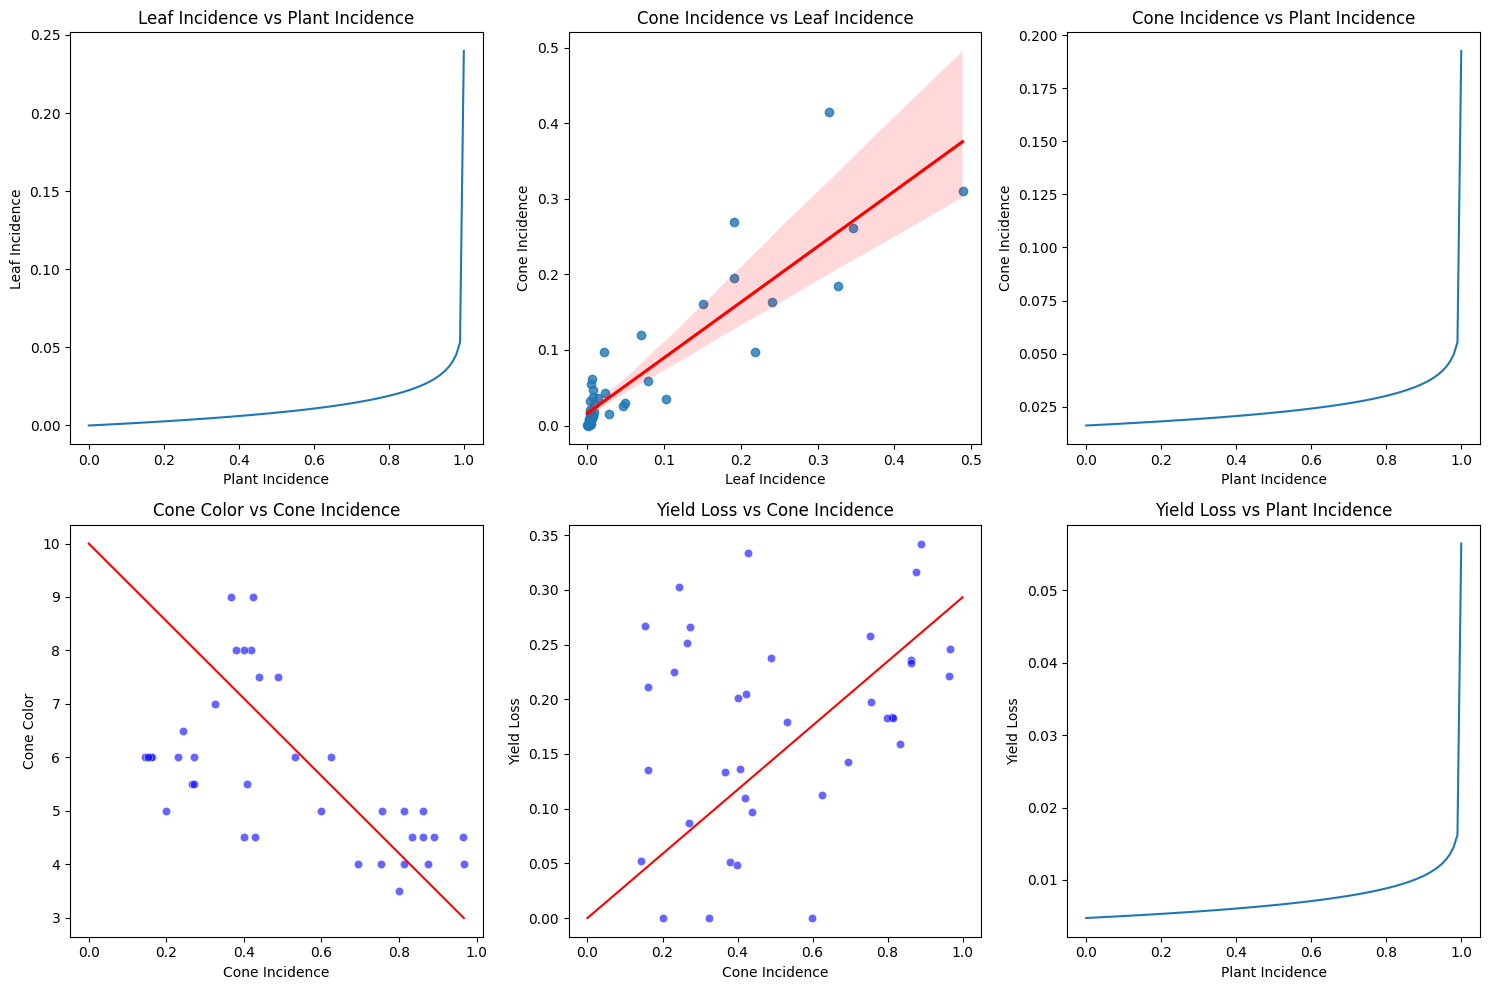

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the leaf_incidence function
def leaf_incidence_function(plant_incidence, n_leaves=100, D=1.19):
    plant_incidence = plant_incidence - 1e-10
    n_D = n_leaves / D
    leaf_incidence = 1 - (1 - plant_incidence) ** (1 / n_D)
    return leaf_incidence

# Define the exponential decay function that passes through (0, 10)
def exp_decreasing(x, a3, b3):
    return 10 + a3 * (1 - np.exp(-b3 * x))

# Create a grid of subplots with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Leaf incidence vs Plant incidence
plant_incidence_vals = np.linspace(0, 1, 100)
leaf_incidence_vals = leaf_incidence_function(plant_incidence_vals)
sns.lineplot(x=plant_incidence_vals, y=leaf_incidence_vals, ax=axes[0, 0])
axes[0, 0].set_xlabel('Plant Incidence')
axes[0, 0].set_ylabel('Leaf Incidence')
axes[0, 0].set_title('Leaf Incidence vs Plant Incidence')

# 2. Cone incidence vs Leaf incidence
sns.regplot(x=data_cone_incidence_leaf_incidence[:, 0], y=data_cone_incidence_leaf_incidence[:, 1], ax=axes[0, 1], line_kws={'color': 'red'})
axes[0, 1].set_xlabel('Leaf Incidence')
axes[0, 1].set_ylabel('Cone Incidence')
axes[0, 1].set_title('Cone Incidence vs Leaf Incidence')

# 3. Cone incidence vs Plant incidence
plant_incidence_vals = np.linspace(0, 1, 100)
leaf_incidence_vals = leaf_incidence_function(plant_incidence_vals)
cone_incidence_vals = a1 * leaf_incidence_vals + b1
sns.lineplot(x=plant_incidence_vals, y=cone_incidence_vals, ax=axes[0, 2])
axes[0, 2].set_xlabel('Plant Incidence')
axes[0, 2].set_ylabel('Cone Incidence')
axes[0, 2].set_title('Cone Incidence vs Plant Incidence')

# 4. Cone color vs Cone incidence (regression)
sns.scatterplot(x=data_cone_color_cone_incidence[:, 0], y=data_cone_color_cone_incidence[:, 1], 
                alpha=0.6, color='blue', ax=axes[1, 0])
x_vals = np.linspace(0, data_cone_color_cone_incidence[:, 0].max(), 100)
y_vals = exp_decreasing(x_vals, a3, b3)
axes[1, 0].plot(x_vals, y_vals, color='red')
axes[1, 0].set_xlabel('Cone Incidence')
axes[1, 0].set_ylabel('Cone Color')
axes[1, 0].set_title('Cone Color vs Cone Incidence')

# 5. Yield loss vs Cone incidence (regression)
sns.scatterplot(x=data_yield_loss_cone_incidence[:, 0], y=data_yield_loss_cone_incidence[:, 1], 
                alpha=0.6, color='blue', ax=axes[1, 1])

# Plot the regression line passing through origin
x_line = np.linspace(0, 1, 100)
y_line = linear_func(x_line, a2)
axes[1, 1].plot(x_line, y_line, color='red', label=f'Regression through origin (y = {a2:.4f}x)')
axes[1, 1].set_xlabel('Cone Incidence')
axes[1, 1].set_ylabel('Yield Loss')
axes[1, 1].set_title('Yield Loss vs Cone Incidence')

# 6. Yield loss vs Plant incidence
plant_incidence_vals = np.linspace(0, 1, 100)
leaf_incidence_vals = leaf_incidence_function(plant_incidence_vals)
cone_incidence_vals = a1 * leaf_incidence_vals + b1
yield_loss_vals = a2 * cone_incidence_vals
sns.lineplot(x=plant_incidence_vals, y=yield_loss_vals, ax=axes[1, 2])
axes[1, 2].set_xlabel('Plant Incidence')
axes[1, 2].set_ylabel('Yield Loss')
axes[1, 2].set_title('Yield Loss vs Plant Incidence')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

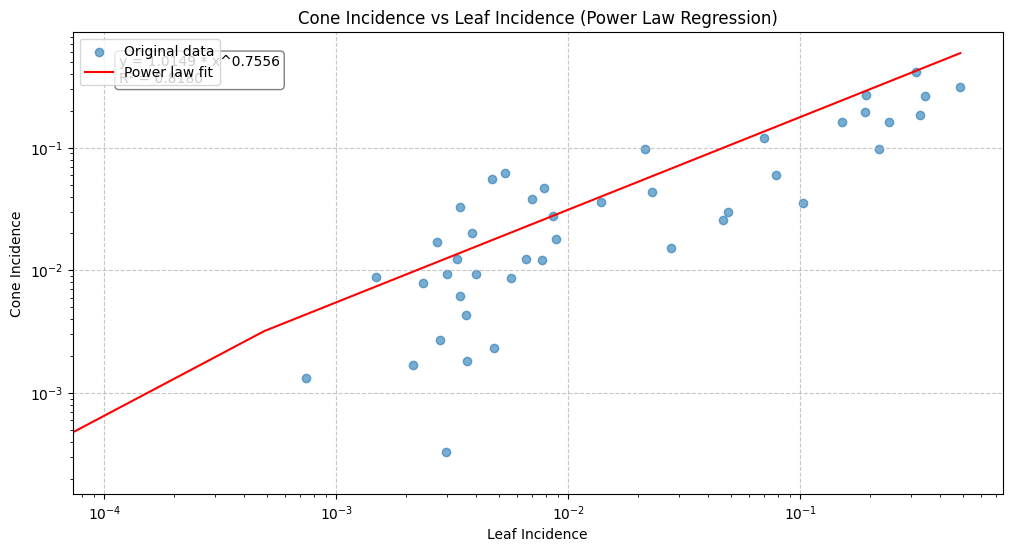

Power law regression results:
y = 1.0149 * x^0.7556
R-squared: 0.8180
p-value: 0.0000


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Load and preprocess data (as before)
df_cone_incidence_leaf_incidence = pd.read_csv('../data/raw/economics/Leaf incidence_vs_Cone_incidence.csv', encoding='utf-8')
df_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.dropna()
data_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.to_numpy()

x = data_cone_incidence_leaf_incidence[:, 0]
y = data_cone_incidence_leaf_incidence[:, 1]

# Apply log transformation
log_x = np.log1p(x)
log_y = np.log1p(y)

# Perform linear regression on log-transformed data
slope, intercept, r_value, p_value, std_err = stats.linregress(log_x, log_y)

# Convert parameters to power law form
alpha = np.exp(intercept)
beta = slope

# Create the plot
plt.figure(figsize=(12, 6))

# Plot original data
plt.scatter(x, y, alpha=0.6, label='Original data')

# Plot power law fit
x_line = np.linspace(x.min(), x.max(), 1000)
y_line = alpha * x_line**beta
plt.plot(x_line, y_line, color='red', label='Power law fit')

# Set labels and title
plt.xlabel('Leaf Incidence')
plt.ylabel('Cone Incidence')
plt.title('Cone Incidence vs Leaf Incidence (Power Law Regression)')

# Use log scale for both axes
plt.xscale('log')
plt.yscale('log')

# Add legend
plt.legend()

# Add text box with regression equation and R-squared
equation = f'y = {alpha:.4f} * x^{beta:.4f}'
r_squared = f'R² = {r_value**2:.4f}'
plt.text(0.05, 0.95, f'{equation}\n{r_squared}', transform=plt.gca().transAxes, 
         verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.5})

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Print the regression results
print(f"Power law regression results:")
print(f"y = {alpha:.4f} * x^{beta:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"p-value: {p_value:.4f}")

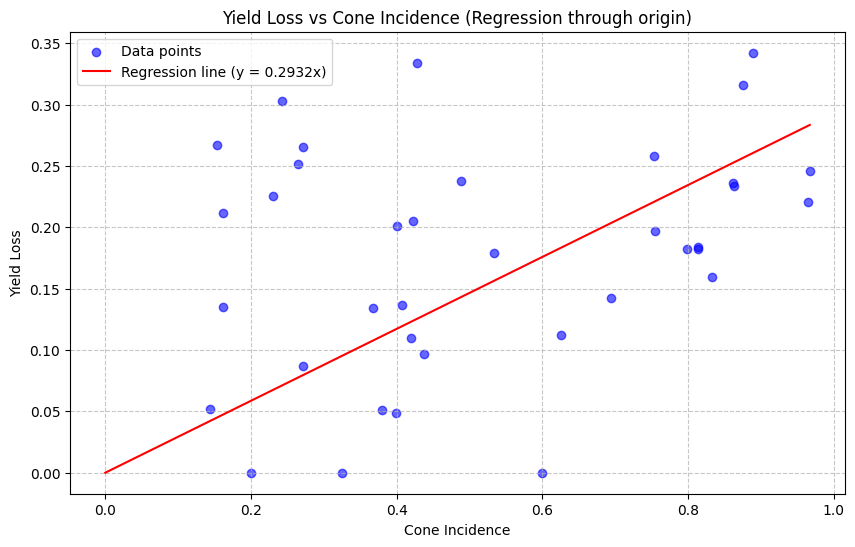

The estimated slope of the regression line is: 0.2932


In [19]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Load the data
df_yield_loss_cone_incidence = pd.read_csv('../data/raw/economics/Cone incidence_vs_Cone  color_vs_Yield_loss.csv', encoding='utf-8')
df_yield_loss_cone_incidence = df_yield_loss_cone_incidence[['Cone incidence', 'Yield Loss']]

# Convert to numpy array
data_yield_loss_cone_incidence = df_yield_loss_cone_incidence.to_numpy()

# Define the linear function passing through origin
def linear_func(x, m):
    return m * x

# Fit the function to the data
slope, _ = curve_fit(linear_func, data_yield_loss_cone_incidence[:, 0], data_yield_loss_cone_incidence[:, 1])

# Extract the slope
a2 = slope[0]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the data points
plt.scatter(data_yield_loss_cone_incidence[:, 0], data_yield_loss_cone_incidence[:, 1], 
            color='blue', alpha=0.6, label='Data points')

# Plot the regression line
x_line = np.linspace(0, np.max(data_yield_loss_cone_incidence[:, 0]), 100)
y_line = linear_func(x_line, a2)
plt.plot(x_line, y_line, color='red', label=f'Regression line (y = {a2:.4f}x)')

# Set labels and title
plt.xlabel('Cone Incidence')
plt.ylabel('Yield Loss')
plt.title('Yield Loss vs Cone Incidence (Regression through origin)')

# Add legend
plt.legend()

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Print the slope
print(f"The estimated slope of the regression line is: {a2:.4f}")

## Heatmap

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Base directory for the files
base_dir = "../data/processed/simulations/percent_change"

year = 2016
market = 'high'

# List of files with directory structure, including the new 0% and 25% infection rate files
files = [
    f"{base_dir}/df_profit_all_0percent_p00001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_0percent_p0001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_0percent_p001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_0percent_p01_{market}_{year}.csv",
    f"{base_dir}/df_profit_all_25percent_p00001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_25percent_p0001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_25percent_p001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_25percent_p01_{market}_{year}.csv",
    f"{base_dir}/df_profit_all_50percent_p00001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_50percent_p0001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_50percent_p001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_50percent_p01_{market}_{year}.csv",
    f"{base_dir}/df_profit_all_75percent_p00001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_75percent_p0001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_75percent_p001_{market}_{year}.csv", 
    f"{base_dir}/df_profit_all_75percent_p01_{market}_{year}.csv",
    f"{base_dir}/df_profit_all_100percent_p00001_{market}_{year}.csv",
    f"{base_dir}/df_profit_all_100percent_p0001_{market}_{year}.csv",
    f"{base_dir}/df_profit_all_100percent_p001_{market}_{year}.csv",
    f"{base_dir}/df_profit_all_100percent_p01_{market}_{year}.csv"
]

# Initialize variables to store the global min and max values
global_min = np.inf
global_max = -np.inf

# First, go through all files to determine global min and max
for file in files:
    df_profit_all = pd.read_csv(file)
    local_min = df_profit_all['mean_profit'].min()
    local_max = df_profit_all['mean_profit'].max()
    
    # Update global min and max
    if local_min < global_min:
        global_min = local_min
    if local_max > global_max:
        global_max = local_max

# Now, plot with a consistent color scale using global_min and global_max
fig, axes = plt.subplots(5, 4, figsize=(20, 25))  # Adjust the size as needed

for i, file in enumerate(files):
    df_profit_all = pd.read_csv(file)
    pivot_profit = df_profit_all.pivot_table(values='mean_profit', index='quantile', columns='lambda_may', aggfunc=np.mean)

    row, col = i // 4, i % 4
    ax = sns.heatmap(pivot_profit, cmap="YlGnBu", annot=False, fmt=".2f", cbar=True, ax=axes[row][col], vmin=-20.0, vmax=0)
    ax.set_title(file.split('/')[-1].split('_')[3].replace("percent", "% V6") + " - " + file.split('/')[-1].split('_')[4].split('.')[0].replace("p0", "init_prob 0."))
    ax.set_xlabel('Number of Sprays in May')
    ax.set_ylabel('quantile of Distance-based Centrality')

plt.tight_layout()
plt.show()

: 

In [2]:
global_max

0.559700313816052

In [3]:
global_min

-16.818430057541704

In [6]:
fung_application_cost

36.61460672578827

In [6]:
global_min, global_max

(-16634.98355248864, -15548.81795411298)

In [8]:
global_min, global_max

(-8354.22525304185, -7512.555652876813)

C:\Users\joshf\AppData\Local\Temp\ipykernel_24780\3106221857.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


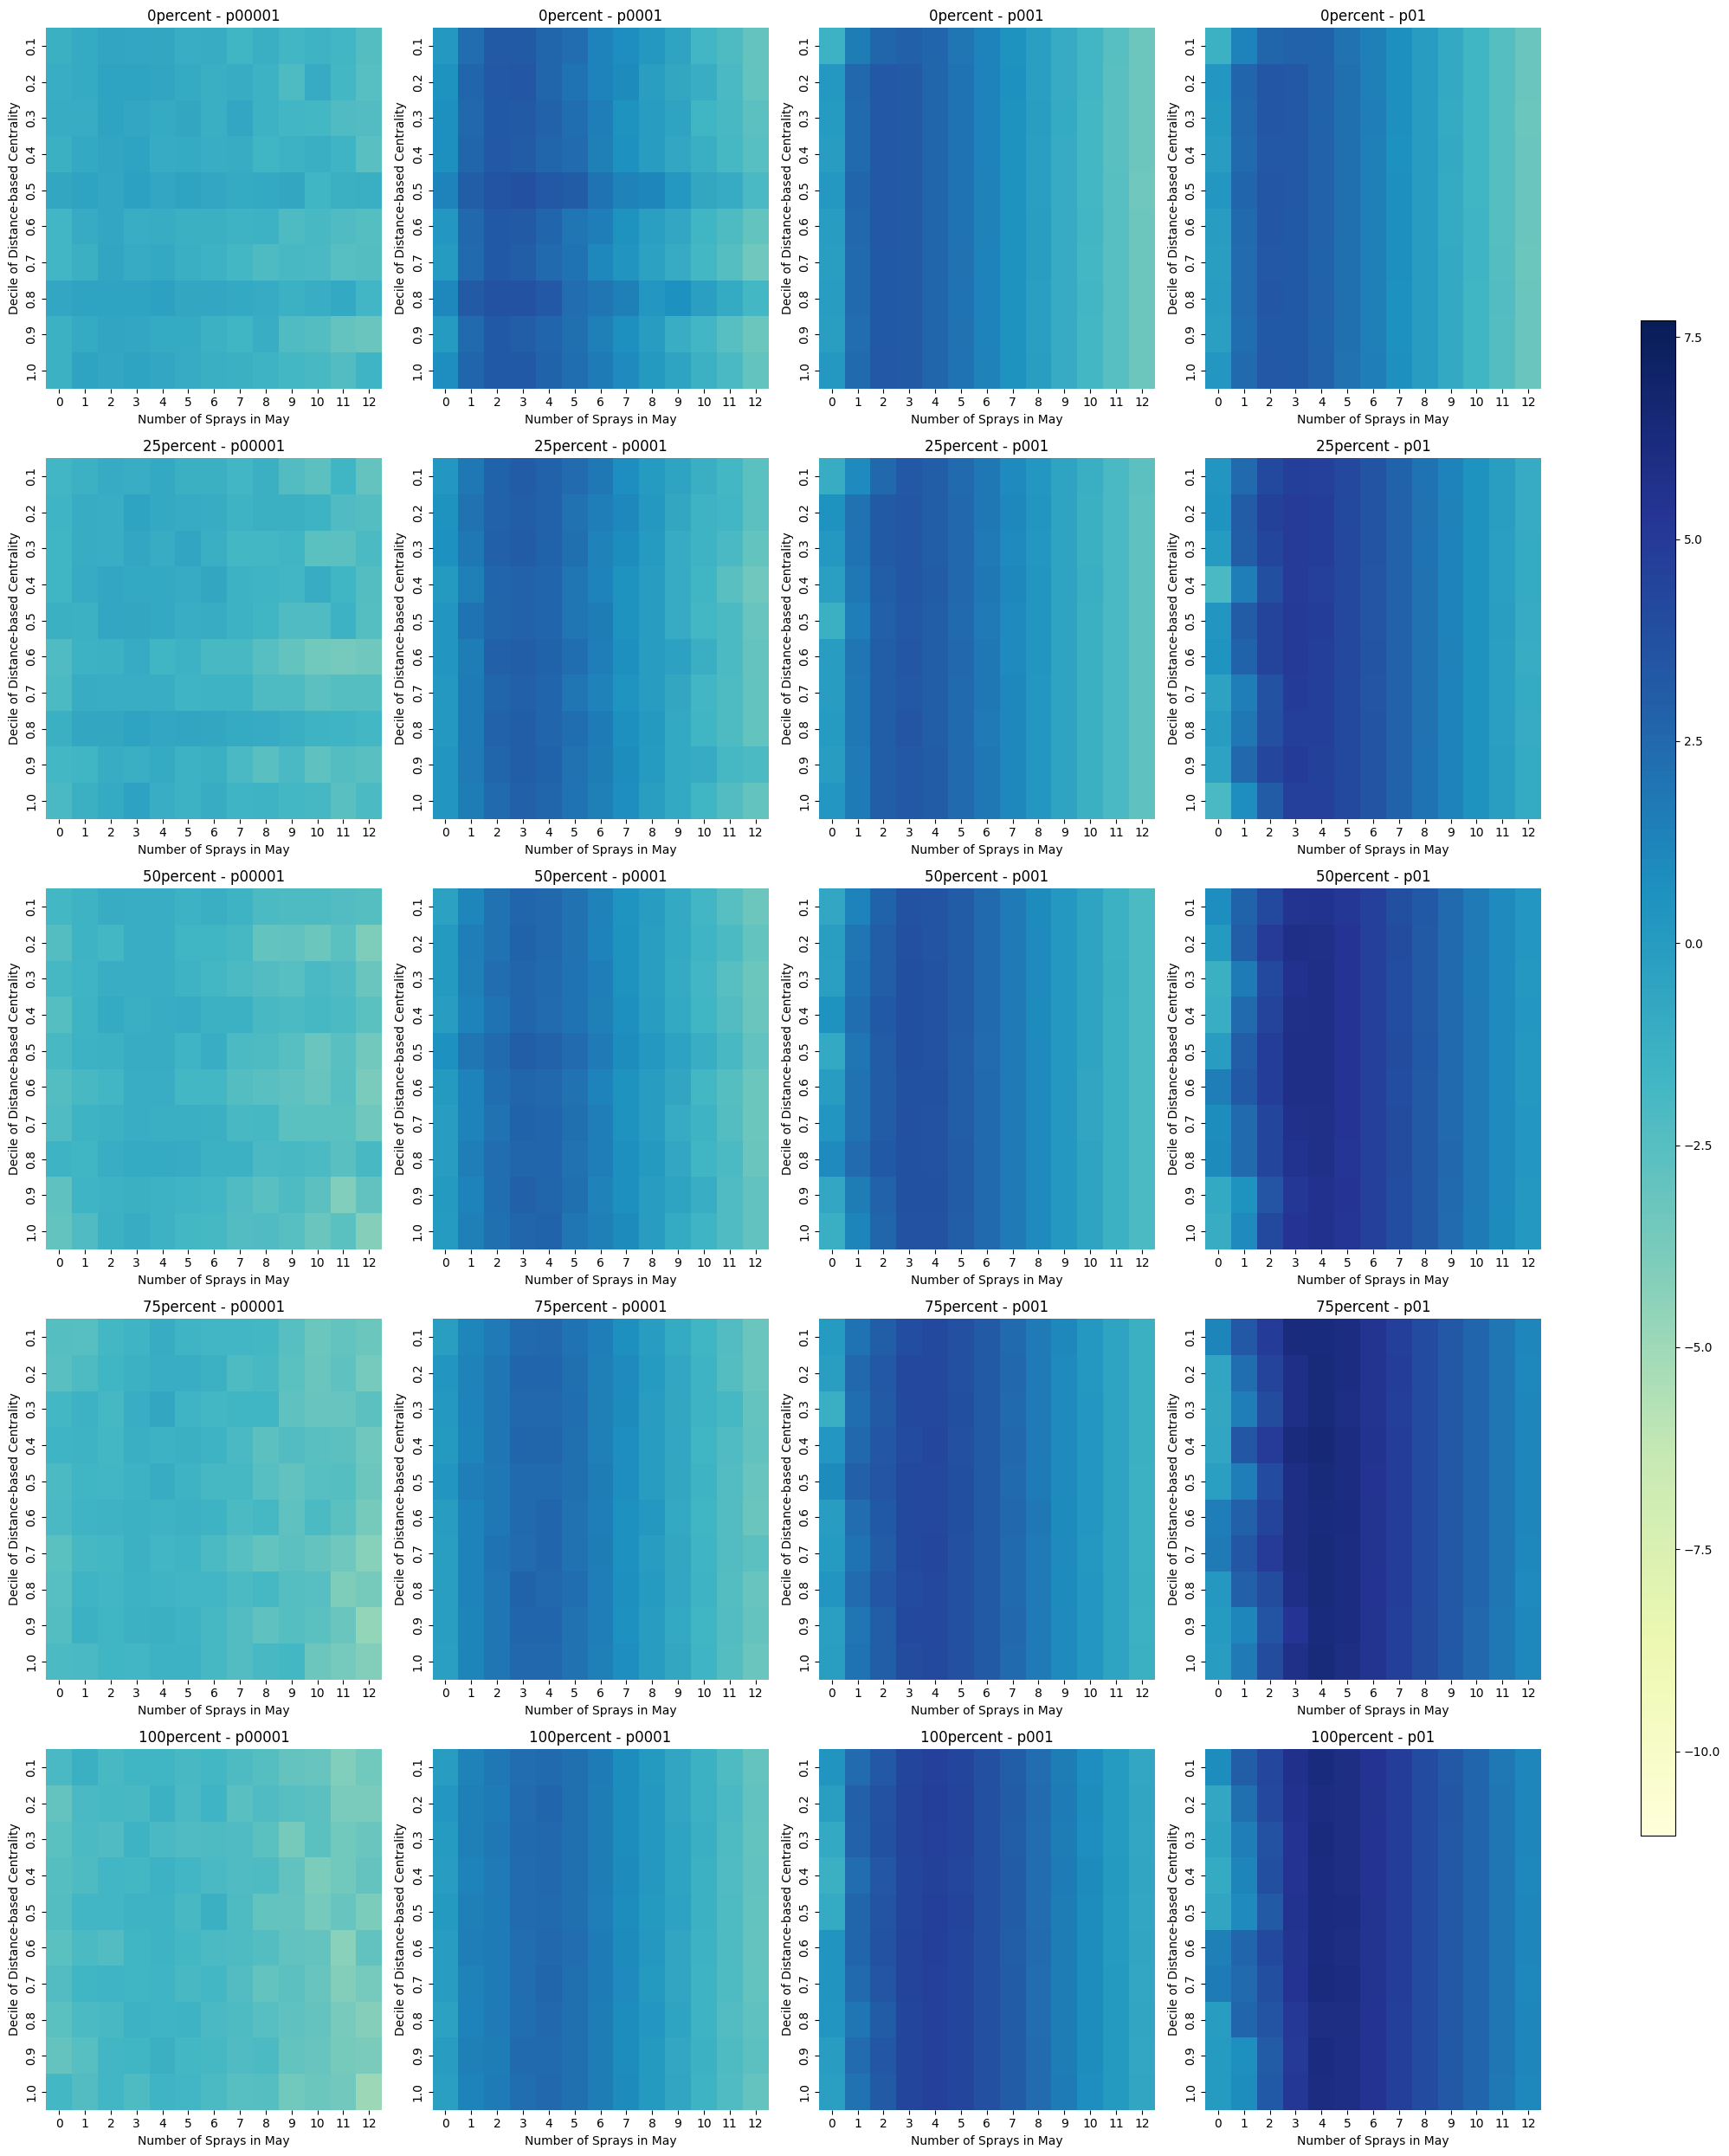

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Base directory for the files (this is just a placeholder in your actual code)
base_dir = "../data/processed/simulations/"

# List of files with directory structure
files = [
    f"{base_dir}/df_profit_all_0percent_p00001_2017.csv", 
    f"{base_dir}/df_profit_all_0percent_p0001_2017.csv", 
    f"{base_dir}/df_profit_all_0percent_p001_2017.csv", 
    f"{base_dir}/df_profit_all_0percent_p01_2017.csv",
    f"{base_dir}/df_profit_all_25percent_p00001_2017.csv", 
    f"{base_dir}/df_profit_all_25percent_p0001_2017.csv", 
    f"{base_dir}/df_profit_all_25percent_p001_2017.csv", 
    f"{base_dir}/df_profit_all_25percent_p01_2017.csv",
    f"{base_dir}/df_profit_all_50percent_p00001_2017.csv", 
    f"{base_dir}/df_profit_all_50percent_p0001_2017.csv", 
    f"{base_dir}/df_profit_all_50percent_p001_2017.csv", 
    f"{base_dir}/df_profit_all_50percent_p01_2017.csv",
    f"{base_dir}/df_profit_all_75percent_p00001_2017.csv", 
    f"{base_dir}/df_profit_all_75percent_p0001_2017.csv", 
    f"{base_dir}/df_profit_all_75percent_p001_2017.csv", 
    f"{base_dir}/df_profit_all_75percent_p01_2017.csv",
    f"{base_dir}/df_profit_all_100percent_p00001_2017.csv",
    f"{base_dir}/df_profit_all_100percent_p0001_2017.csv",
    f"{base_dir}/df_profit_all_100percent_p001_2017.csv",
    f"{base_dir}/df_profit_all_100percent_p01_2017.csv"
]

# Initialize variables to store the global min and max values
global_min = float('inf')
global_max = float('-inf')

# First, iterate over files to find the global min and max values for 'mean_profit'
for file in files:
    df_profit_all = pd.read_csv(file)
    local_min = df_profit_all['mean_profit'].min()
    local_max = df_profit_all['mean_profit'].max()
    global_min, global_max = min(global_min, local_min), max(global_max, local_max)

# Now, set up the matplotlib figure with 5x4 layout
fig, axes = plt.subplots(5, 4, figsize=(20, 25))

# Then, plot each heatmap with the uniform color scale
for i, file in enumerate(files):
    # Load the data
    df_profit_all = pd.read_csv(file)

    # Create pivot table
    pivot_profit = df_profit_all.pivot_table(values='mean_profit', index='quantile', columns='lambda_may', aggfunc=np.mean)

    # Plot heatmap with uniform color scale
    row, col = i // 4, i % 4
    sns.heatmap(pivot_profit, cmap="YlGnBu", annot=False, fmt=".2f",
                cbar=False, ax=axes[row][col], vmin=global_min, vmax=global_max)
    axes[row][col].set_title(file.split('/')[-1].split('_')[3] + " - " + file.split('/')[-1].split('_')[4].split('.')[0])
    axes[row][col].set_xlabel('Number of Sprays in May')
    axes[row][col].set_ylabel('quantile of Distance-based Centrality')

# Add a common color bar
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
norm = plt.Normalize(global_min, global_max)
sm = plt.cm.ScalarMappable(cmap="YlGnBu", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

In [7]:
m

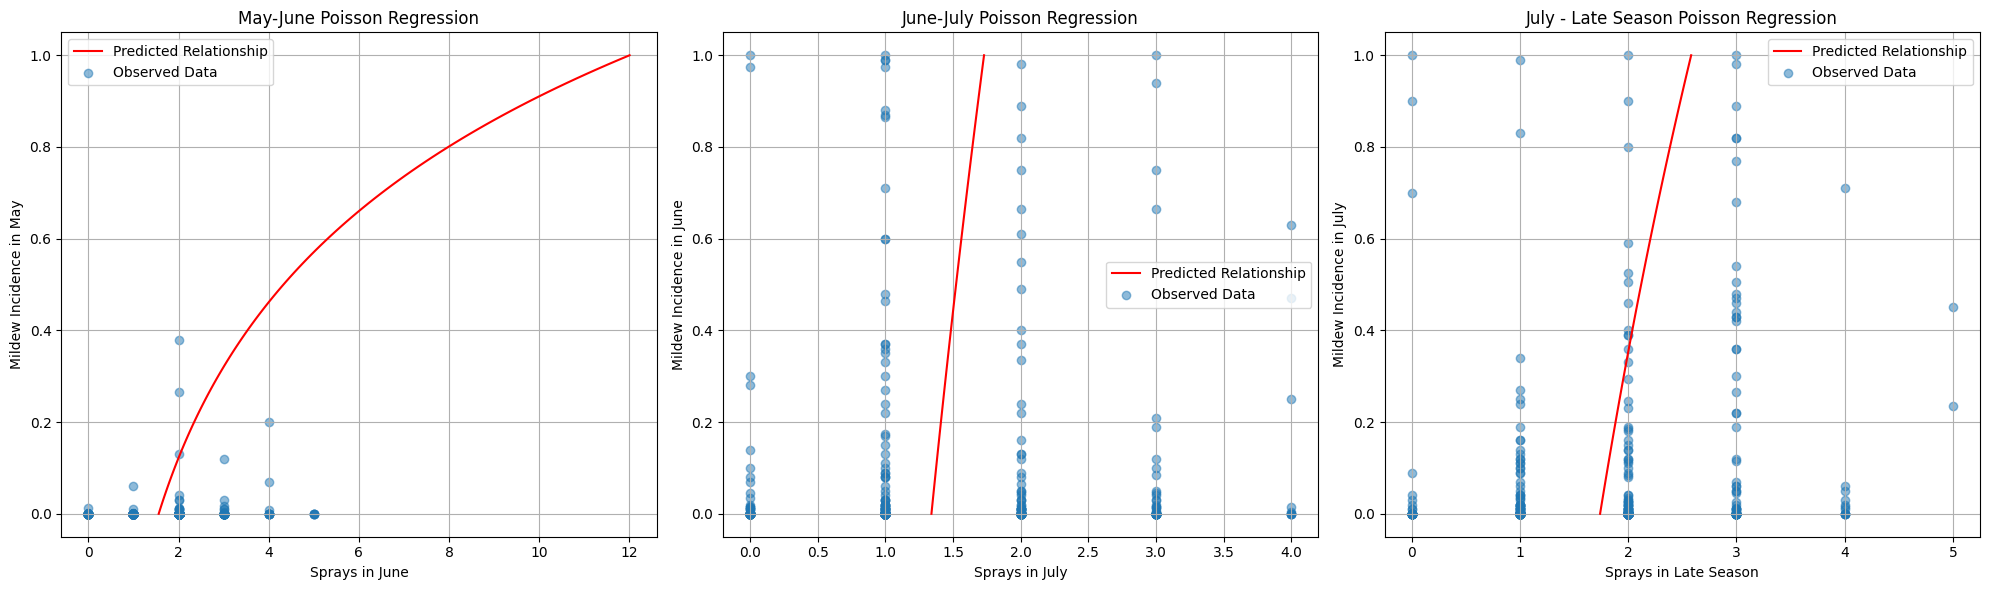

In [28]:
# SYNTHETIC SPRAY DATA / POISSON REGRESSION

import pandas as pd
import statsmodels.api as sm

# MAY-JUNE
# Define the dependent (response) variable and the independent (predictor) variable
X_may = df[(df['Month'] == 'May')]['Mildew Incidence'].reset_index(drop=True)
y_jun = df[(df['Month'] == 'June')]['Sprays'].reset_index(drop=True)

# Add a constant to the predictor variables (it's a best practice)
X_may = sm.add_constant(X_may)

# Fit the Poisson regression model
pois_may_jun = sm.GLM(y_jun, X_may, family=sm.families.Poisson()).fit()


# JUNE-JULY
# Define the dependent (response) variable and the independent (predictor) variable
X_jun = df[(df['Month'] == 'June')]['Mildew Incidence'].reset_index(drop=True)
y_jul = df[(df['Month'] == 'July')]['Sprays'].reset_index(drop=True)

# Add a constant to the predictor variables (it's a best practice)
X_jun = sm.add_constant(X_jun)

# Fit the Poisson regression model
pois_jun_jul = sm.GLM(y_jul, X_jun, family=sm.families.Poisson()).fit()

# JULY-LATE SEASON
late_df = pd.read_csv('../data/processed/late_cost_data.csv', encoding='utf-8')

# Define the dependent (response) variable and the independent (predictor) variable
X_jul = df[(df['Month'] == 'July')]['Mildew Incidence'].reset_index(drop=True)
y_late = late_df['Sprays'].reset_index(drop=True)

# Add a constant to the predictor variables (it's a best practice)
X_jul = sm.add_constant(X_jul)

# Fit the Poisson regression model
pois_jul_late = sm.GLM(y_late, X_jul, family=sm.families.Poisson()).fit()
# END JULY-LATE SEASON

# Print the summary of the regression
#print(model.summary())


# Generate a range of mildew incidence values
mildew_range = np.linspace(0, 1, 100)

# Create a DataFrame with these values and a constant
predict_df = pd.DataFrame({'Mildew Incidence': mildew_range})
predict_df = sm.add_constant(predict_df)

# Predict the number of sprays for May-June and June-July
predicted_sprays_may_jun = pois_may_jun.predict(predict_df)
predicted_sprays_jun_jul = pois_jun_jul.predict(predict_df)
predicted_sprays_late = pois_jul_late.predict(predict_df)

# Create a figure and a 1x2 grid of subplots
plt.figure(figsize=(20, 6))

# May-June Poisson Regression
plt.subplot(1, 3, 1)
plt.plot(predicted_sprays_may_jun, mildew_range, '-r', label='Predicted Relationship')
plt.scatter(y_jun, X_may['Mildew Incidence'], alpha=0.5, label='Observed Data')
plt.ylabel('Mildew Incidence in May')
plt.xlabel('Sprays in June')
plt.legend()
plt.title('May-June Poisson Regression')
plt.grid(True)

# June-July Poisson Regression
plt.subplot(1, 3, 2)
plt.plot(predicted_sprays_jun_jul, mildew_range, '-r', label='Predicted Relationship')
plt.scatter(y_jul, X_jun['Mildew Incidence'], alpha=0.5, label='Observed Data')
plt.ylabel('Mildew Incidence in June')
plt.xlabel('Sprays in July')
plt.legend()
plt.title('June-July Poisson Regression')
plt.grid(True)

# July-Late season Poisson Regression
plt.subplot(1, 3, 3)
plt.plot(predicted_sprays_late, mildew_range, '-r', label='Predicted Relationship')
plt.scatter(y_late, X_jul['Mildew Incidence'], alpha=0.5, label='Observed Data')
plt.ylabel('Mildew Incidence in July')
plt.xlabel('Sprays in Late Season')
plt.legend()
plt.title('July - Late Season Poisson Regression')
plt.grid(True)

plt.tight_layout()
plt.show()

In [29]:
# Step 1: Filter and convert to NumPy arrays
may_incidence = df[df['Month'] == 'May']['Mildew Incidence'].to_numpy()
june_incidence = df[df['Month'] == 'June']['Mildew Incidence'].to_numpy()
july_incidence = df[df['Month'] == 'July']['Mildew Incidence'].to_numpy()

# Step 2: Sum the arrays
total_incidence = may_incidence + june_incidence + july_incidence

# Step 3: Calculate the mean across the months
mean_incidence = total_incidence / 3

# Convert the mean back to a pandas Series (if needed)
mean_incidence_series = pd.Series(mean_incidence)

# JULY-LATE SEASON
late_df = pd.read_csv('../data/processed/late_cost_data.csv', encoding='utf-8')

# Define the dependent (response) variable and the independent (predictor) variable
X_mean = mean_incidence_series.reset_index(drop=True)
y_late = late_df['Sprays'].reset_index(drop=True)

# Add a constant to the predictor variables (it's a best practice)
X_mean = sm.add_constant(X_mean)

# Fit the Poisson regression model
pois_mean_late = sm.GLM(y_late, X_mean, family=sm.families.Poisson()).fit()

# AIC for the original model using only July
aic_july = pois_jul_late.aic

# AIC for the model using the mean incidence over May, June, and July
aic_mean = pois_mean_late.aic

print("AIC for July only model: ", aic_july)
print("AIC for mean incidence model: ", aic_mean)


AIC for July only model:  1321.4949554900054
AIC for mean incidence model:  1321.5479123827724


In [38]:
list(np.array([2.5, 4.25, 6.0]) / ppi_2021 * 100)

[2.7801462130648655, 4.726248562210271, 6.672350911355678]